In [1]:
%reload_ext autoreload
%autoreload 2

# %matplotlib qt

import time
from tqdm import tqdm
import numpy as np
import scipy as sp
import sklearn
import torch
import torch.nn.functional as F
from torch import nn
from torchvision.transforms import v2 as transforms

from matplotlib import pyplot as plt

from networkAlignmentAnalysis.models.registry import get_model
from networkAlignmentAnalysis.datasets import get_dataset
from networkAlignmentAnalysis.experiments.registry import get_experiment
from networkAlignmentAnalysis import utils
from networkAlignmentAnalysis import files
from networkAlignmentAnalysis import train

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('using device: ', DEVICE)

using device:  cuda


In [2]:
# TODO
# 1.1. include additional AlignmentModel methods stored in extra class in base model

# Basic alignment_comparison Analyses (or maybe for alignment_stats):
# - compare initial to final alignment...
# - compare initial alignment to delta weight norm...
# - observe alignment of delta weight
# - compare alignment to outgoing delta weight norm!

# Eigenfeature analyses:
# done: - start by just looking at amplitude of activity on each eigenvector within each layer
# done: - Determine contribution of each eigenfeature on performance with a eigenvector dropout experiment
# - Measure beta_adversarial (figure out how adversarial examples map onto eigenvectors)

# forward_eigenvector_dropout is slow... maybe because cpu->gpu overhead? 

# alignmentShaping.ipynb has an adversarial experiment worth looking at
# need to integrate manual shaping!!!!

# Consider Valentin's idea about measuring an error threshold given signal and noise for a given level of alignment
# e.g. plot a 2d heatmap comparing the noise amplitude and the average alignment
# and then think about how to apply this to network design...

# convert batch_cov to allow for batch_corr too (and make it "smart" with zero-var handling)
# integrate batched alignment into pipeline  (there's test code in the tests directory)

In [2]:
model_name = 'MLP'
dataset_name = 'MNIST'

net = get_model(model_name, build=True, dataset=dataset_name, dropout=0.0)
net.to(DEVICE)

loader_parameters = dict(
    shuffle=True,
)
dataset = get_dataset(dataset_name, build=True, transform_parameters=net, loader_parameters=loader_parameters, device=DEVICE)

In [6]:
t = time.time()

inputs, _ = net._process_collect_activity(dataset,
                                          train_set=True,
                                          with_updates=False,
                                          use_training_mode=False)

_, eigenvalues, eigenvectors = net.measure_eigenfeatures(inputs, with_updates=False)

print(time.time() - t)

0.8054075241088867


In [16]:
weights = net.get_alignment_weights()
print([w.shape for w in weights])

def get_invar(inputs_to_layers, weights):
    invar = []
    for i, w in zip(inputs_to_layers, weights):
        a = torch.matmul(i, w.T)
        invar.append(torch.var(a, dim=0))
    return invar

def get_outvar(outputs_from_layers):
    return [torch.var(o, dim=0) for o in outputs_from_layers]

inputs = []
for batch in dataset.test_loader:
    image, label = dataset.unwrap_batch(batch)
    inputs.append(image)
inputs = torch.cat(inputs, dim=0)

whole = True
with torch.no_grad():
    if whole:
        inputs_to_layers = net.get_layer_inputs(inputs, precomputed=False)
        outputs_from_layers = net.get_layer_outputs(inputs, precomputed=True)
        alignment = net.measure_alignment(inputs, precomputed=True)
        inner_variance = get_invar(inputs_to_layers, weights)
        outer_variance = get_outvar(outputs_from_layers)

    else:
        alignment = []
        inner_variance = []
        outer_variance = []
        for batch in dataset.test_loader:
            images, label = dataset.unwrap_batch(batch)
            out = net(images, store_hidden=True)
            inputs_to_layers = net.get_layer_inputs(images, precomputed=True)
            outputs_from_layers = net.get_layer_outputs(images, precomputed=True)
            alignment.append(net.measure_alignment(images, precomputed=True))
            inner_variance.append(get_invar(inputs_to_layers, weights))
            outer_variance.append(get_outvar(outputs_from_layers))

        alignment = [torch.stack(a) for a in utils.transpose_list(alignment)]
        inner_variance = [torch.stack(iv) for iv in utils.transpose_list(inner_variance)]
        outer_variance = [torch.stack(ov) for ov in utils.transpose_list(outer_variance)]

[torch.Size([100, 784]), torch.Size([100, 100]), torch.Size([50, 100]), torch.Size([10, 50])]


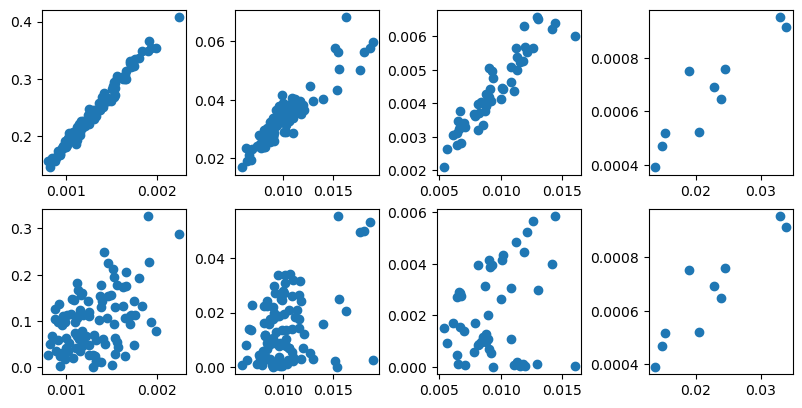

In [41]:
num_layers = len(alignment)

plt.close('all')
fig, ax = plt.subplots(2, num_layers, figsize=(2*num_layers, num_layers), layout='constrained')
for ii, (a, iv, ov) in enumerate(zip(alignment, inner_variance, outer_variance)):
    ax[0, ii].scatter(a.cpu().numpy(), iv.cpu().numpy())
    ax[1, ii].scatter(a.cpu().numpy(), ov.cpu().numpy())
plt.show()

{}


100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


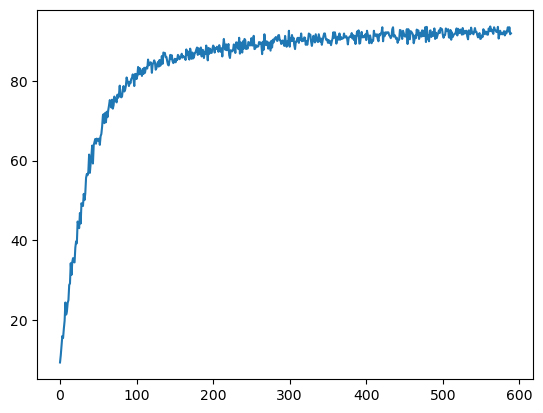

[tensor(95.9620)]


In [17]:
results = train.train(nets, optimizers, dataset, num_epochs=50, alignment=False)
test_results = train.test(nets, dataset, train=False, alignment=False)

all_images, _ = utils.named_transpose([net._process_collect_activity(dataset, train_set=False, with_updates=False) for net in nets])
_, _, eigenvectors = utils.named_transpose([net.measure_eigenfeatures(images, with_updates=False)
                                            for net, images in zip(nets, all_images)])

# dropout_results = train.eigenvector_dropout([net], dataset, [eigenvalue], [eigenvector], train_set=False, by_layer=True)

plt.close('all')
plt.plot(results['accuracy'])
plt.show()

print(test_results['accuracy'])

In [38]:
fgsm_transform = lambda x: x

def fgsm_attack(image, epsilon, data_grad, transform, sign):
    # Collect the element-wise sign of the data gradient
    if sign:
        data_grad = data_grad.sign()
    else:
        data_grad = data_grad.clone()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = transform(perturbed_image)
    # Return the perturbed image
    return perturbed_image

def get_beta(inputs, eigenvectors):
    betas = [input.cpu() @ evec for input, evec in zip(inputs, eigenvectors)]
    # betas = [torch.sqrt(torch.mean(beta**2, dim=0)) for beta in betas]
    return betas

@utils.test_nets
def test(nets, dataset, epsilon, eigenvectors, sign=True, train=True):
    num_eps = len(epsilon)
    num_nets = len(nets)
    accuracy = torch.zeros((num_nets, num_eps))
    examples = [[[] for _ in range(num_eps)] for _ in range(num_nets)]
    betas = [[torch.zeros((num_nets, evec.size(0))) for evec in eigenvectors[0]]
             for _ in range(num_eps)]

    # dataloader
    dataloader = dataset.train_loader if train else dataset.test_loader

    for batch in tqdm(dataloader):
        input, labels = dataset.unwrap_batch(batch)
        
        inputs = [input.clone() for _ in range(num_nets)]

        for input in inputs:
            input.requires_grad = True

        # Forward pass the data through the model
        outputs = [net(input, store_hidden=True) for net, input in zip(nets, inputs)]
        input_to_layers = [net.get_layer_inputs(input, precomputed=True) for net in nets]
        init_preds = [torch.argmax(output,axis=1) for output in outputs] # find true prediction
        least_likely = [torch.argmin(output,axis=1) for output in outputs] # find least likely digit according to model
        
        c_betas = utils.transpose_list([get_beta(input, evec) for input, evec in zip(input_to_layers, eigenvectors)])
        s_betas = [torch.stack(cb) for cb in c_betas]

        # Calculate the loss
        loss = [dataset.measure_loss(output, labels) for output in outputs]
        # loss = dataset.measure_loss(output, least_likely)

        # Zero all existing gradients
        for net in nets:
            net.zero_grad()

        # Calculate gradients of model in backward pass
        for l in loss:
            l.backward()

        # Collect datagrad
        data_grads = [input.grad.data for input in inputs]
        
        for epsidx, eps in enumerate(epsilon):
            
            # Call FGSM Attack
            perturbed_inputs = [fgsm_attack(input, eps, data_grad, fgsm_transform, sign)
                                for input, data_grad in zip(inputs, data_grads)]

            # Re-classify the perturbed image
            outputs = [net(perturbed_input, store_hidden=True)
                       for net, perturbed_input in zip(nets, perturbed_inputs)]
            input_to_layers = [net.get_layer_inputs(perturbed_input, precomputed=True)
                               for net, perturbed_input in zip(nets, perturbed_inputs)]
            c_eps_betas = utils.transpose_list([get_beta(input, evec) for input, evec in zip(input_to_layers, eigenvectors)])
            s_eps_betas = [torch.stack(ceb) for ceb in c_eps_betas]
            d_eps_betas = [sebeta - sbeta for sebeta, sbeta in zip(s_eps_betas, s_betas)]
            rms_betas = [torch.sqrt(torch.mean(db**2, dim=1)) for db in d_eps_betas]

            for ii, rbeta in enumerate(rms_betas):
                betas[epsidx][ii] += rbeta

            # Check for success
            final_preds = [torch.argmax(output, axis=1) for output in outputs]
            accuracy[:, epsidx] += torch.tensor([sum(final_pred==labels).cpu() for final_pred in final_preds])
            
            # Idx where adversarial example worked
            idx_success = [torch.where((init_pred==labels) & (final_pred != labels))[0].cpu()
                           for init_pred, final_pred in zip(init_preds, final_preds)]
            
            adv_exs = [perturbed_input.detach().cpu().numpy() for perturbed_input in perturbed_inputs]
            for ii, (adv_ex, idx, init_pred, final_pred) in enumerate(zip(adv_exs, idx_success, init_preds, final_preds)):
                examples[ii][epsidx].append((init_pred[idx], final_pred[idx], adv_ex[idx]))

    # Calculate final accuracy for this epsilon
    accuracy = accuracy / float(len(dataloader.dataset))

    # Average across betas
    betas = [[cb / float(len(dataloader.dataset)) for cb in beta] for beta in betas]
        
    # Return the accuracy and an adversarial example
    return accuracy, betas, examples


epsilons = np.linspace(0,1,31)
# epsilons = np.hstack((0, np.logspace(2,4,5)))
# epsilons = np.hstack((0, np.linspace(10,100000,21)))
sign = True

num_eps = len(epsilons)
num_nets = len(nets)

prtAccuracy = torch.zeros((num_eps, num_nets))
newAccuracy = torch.zeros((num_eps, num_nets))

# Run test for each epsilon
acc, betas, ex = test(nets, dataset, epsilons, eigenvectors, sign=sign, train=False)

100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


In [39]:
names = ['full', 'dropout']

plt.close('all')
for name, a in zip(names, acc):
    plt.plot(epsilons, a, label=name)
plt.legend()
plt.show()

In [71]:
from scipy.signal import savgol_filter

plt.close('all')
fig, ax = plt.subplots(1, len(betas[0]), figsize=(12, 3), layout='constrained')
for ii, beta in enumerate(betas[10]):
    ax[ii].plot(range(beta.size(1)), savgol_filter(beta[0].detach() / torch.sum(beta[0].detach()), 5, 1), label='vanilla')
    ax[ii].plot(range(beta.size(1)), savgol_filter(beta[1].detach() / torch.sum(beta[1].detach()), 5, 1), label='dropout')
    ax[ii].set_xlabel('PC Dimension')
    ax[ii].set_ylabel('Projection of adversarial perturbation')
plt.legend()
plt.show()

In [82]:
len(betas[10])

4